## 1. Load required packages

We load GIRAFFE and other required packages. PANDA and OTTER are available on netZooPy. Feel free to check [here](https://netzoopy.readthedocs.io/en/latest/install/index.html) for more information about installing netZooPy. 

In [1]:
import giraffe
import matplotlib.pyplot as plt
import networkx as nx
from netZooPy.otter.otter import otter
from netZooPy.panda.panda import Panda 
import numpy as np
from numpy.random import default_rng
import pandas as pd
import random
import scipy
from scipy import stats

## 2. Recovering ground-truth from model satisfying our assumptions

We create a toy dataset to show that GIRAFFE performs well under its assumptions. We need to generate the true regulation matrix R, the transcription factor activity matrix TFA, the PPI network, the gene expression, and the motif. The number of genes, transcription factors, and samples are picked to be coherent with the typical biological setting. 

In [2]:
TF = 100  # Number of transcription factors
G = 500  # Number of genes
n = 50  # Number of samples

We start with the PPI network, an undirected graph where the degree of each edge is sampled according to the distribution observed on real data. 

In [3]:
def generate_ppi(tf):
    sample_ppi = pd.read_csv('data/sample_data/PPI.csv') #  PPI from human data
    degree = nx.degree_histogram(nx.from_numpy_matrix(sample_ppi.to_numpy()))
    degree_prob = [d / np.sum(degree) for d in degree] #  Degree distribution for each node
    
    #  Sample degrees for each node according to distribution observed in real data
    D = random.choices(population = [i for i in range(len(degree_prob))], weights = degree_prob, k = tf)
    G = nx.expected_degree_graph(D) 
    PPI = nx.to_numpy_array(G) #  Create undirected PPI network
    np.fill_diagonal(PPI, 1) #  By definition, transcription factors interact with themselves
    giraffe.utils.check_symmetric(PPI) #  Sanity check
    return PPI

We assume that transcription factors form a protein complex if they form a clique in the PPI. The next piece of code return the cliques, i.e. the protein complexes, for every transcription factor. 

In [4]:
def find_cliques(ppi) :
    """
    Returns a maps from a transcription factor to the id of the cliques it belongs to
    """
    G = nx.from_numpy_array(ppi)
    cliques = {}
    idx = 0
    for i in nx.find_cliques(G):
        if len(i) > 1:
            for protein in i:
                if protein in cliques.keys():
                    cliques[protein] = cliques[protein] + [idx]
                else:
                    cliques[protein] = [idx]
            idx += 1
    # idx: number of cliques in ppi
    # map from transcription factor to its cliques (cliques of size 1 are neglected)
    return idx, cliques

At this point we are ready to generate the TFA matrix. For each protein complex we generate its activity. The row corresponding to a given transcription factor is the sum of the quantity of its protein complexes.If a transcription factor is not part of a protein complex, we assume that it regulates genes independently from the others. 

In [29]:
def generate_tfa(ppi, n):
    tf = ppi.shape[0]
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_quantity = np.zeros((n, cliques_no)) #  quantity for each protein complex
    
    #  Generate quantity for each complex
    for i in range(cliques_no) :
        A = np.random.uniform(0, 10, n)
        cliques_quantity[:, i] = A
    
    # The quantity for each tf is the sum of the cliques it belongs to
    TFA = np.zeros((tf, n))
    for k, v in cliques.items() :
        TFA[k, :] = np.sum(cliques_quantity[:, [v]])
    
    # If a transcription factor is not part of a complex, it can still be active
    for i in range(tf) :
        if np.sum(TFA[i, :]) == 0 :
            TFA[i, :] = np.random.uniform(0, 10, n)
            
    return TFA #  Generated matrix

The mechanism to generate the true regulation matrix (which serves as ground-truth to estimate the performance) is similar: each protein complex (i.e. each clique in the PPI) has a sparse regulation vector describing its relationship with the target genes. Hence, for for each column in R, we sum the generated regulation vectors for each protein complex the transcription factor belongs to. If a transcription factor is not part of any complex, it can still regulate genes independently. 

In [37]:
def generate_regulation(g, tf, ppi) :
    sparsity = 0.1
    rng = default_rng()
    rvs = stats.uniform(loc = -1, scale = 2).rvs
    
    R = np.zeros((g, tf)) #  To store the ground-truth regulation matrix
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_to_regulation = np.zeros((g, cliques_no)) #  How much each clique regulates the genes
    
    for i in range(cliques_no) :
        regulation = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A
        cliques_to_regulation[:, i] = regulation.flatten()
    
    for k, v in cliques.items() :
        R[:, k] = np.sum(cliques_to_regulation[:, [v]])
    
    #  If a transcription factor is not part of any clique, it can still regulate gene expression 
    for i in range(tf) :
        if np.sum(R[:, i]) == 0 :
            R[:, i] = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A.flatten()
            
    return R #  Generated matrix

We generate a binary motif as follows. First, we map each non-zero entry of R to one, resulting in a binary matrix. Then we we flip a certain number of entries, such that a zero (i.e. no regulation) becomes a one (i.e. regulation) and viceversa. The ratio of flipped bits is passed as the parameter shuffle to the function. 

In [7]:
def generate_motif(R, shuffle = 0.2):
    motif = R.copy()
    motif[motif != 0] = 1
    to_shuffle = int(motif.shape[0] * motif.shape[1] * shuffle)
    for i in range(to_shuffle) :
        x = np.random.randint(0, R.shape[0])
        y = np.random.randint(0, R.shape[1])
        if motif[x, y] == 1 :
            motif[x, y] = 0
        else :
            motif[x, y] = 1
    return motif

The expression matrix is generated as the product of the ground-truth matrices R and TFA. This is coherent with our underlying assumption that gene expression can be factorized as this product. 

In [17]:
def compute_expression(R, TFA, confounder = None) :
    res = R.dot(np.abs(TFA))
    if confounder is None:
        return res
    return res + np.array([confounder for i in range(R.shape[0])])

Now we have generators for all required data: a ground-truth regulation matrix, a corrupter motif, and a PPI netork. We are ready to put the pieces together in our simulation. 

In [35]:
def simulation(n = 50, shuffling = 0.2):
    tf = 100
    g = 500

    ppi = generate_ppi(tf)
    TFA = generate_tfa(ppi, n)
    R = generate_regulation(g, tf, ppi)
    gene_expression = compute_expression(R, TFA)
    motif = generate_motif(R, shuffling)
    
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 1e-4).get_regulation()
    R_otter = otter(motif.T, ppi, np.corrcoef(gene_expression), Iter = 200).T
    R_panda = giraffe.compute_panda_locally(gene_expression, motif, ppi)
    return giraffe.plot_auroc(R, [R_giraffe, R_otter, R_panda, motif], ["Our method", "OTTER", "PANDA", "Motif"], title = "AUROC, reliability of the motif = " + str(1 - shuffling))

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.08 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    434395.013752  434413.279618  434412.982546  434411.548376   
1    434411.367692  434426.926776  434407.073661  434416.884057   
2    434405.617657  434377.428109  434375.416092  434369.859236   
3    434411.159373  434398.570470  434423.247356  434404.170558   
4    434433.034441  434429.775392  434428.808978  434436.592528   
..             ...            ...            ...            ...   
495  434417.365896  434425.525464  434402.585439  434400.186464   
496  434405.471764  434408.152880  434390.948935  434411.418550   
497  434404.535971  434433.971591  434411.529797  434433.735127   
498  434371.115548  434402.

step: 106, hamming: 632329668.8169951
step: 107, hamming: 716674014.6248821
step: 108, hamming: 800838451.9361125
step: 109, hamming: 877268173.4282568
step: 110, hamming: 936802556.807276
step: 111, hamming: 970637137.8948176
step: 112, hamming: 973008551.6254551
step: 113, hamming: 943260938.1176045
step: 114, hamming: 886002015.9035947
step: 115, hamming: 809292684.3885552
step: 116, hamming: 722072942.133247
step: 117, hamming: 632136363.7665998
step: 118, hamming: 545184069.6049715
step: 119, hamming: 464767970.1156658
step: 120, hamming: 392691224.95601434
step: 121, hamming: 329525179.59175164
step: 122, hamming: 275065434.8389961
step: 123, hamming: 228673406.70796424
step: 124, hamming: 189506196.0637798
step: 125, hamming: 156660756.48242444
step: 126, hamming: 129257715.24065343
step: 127, hamming: 106485208.18458158
step: 128, hamming: 87618436.01810768
step: 129, hamming: 72024836.70564656
step: 130, hamming: 59160700.04918243
step: 131, hamming: 48564057.17235595
step: 13

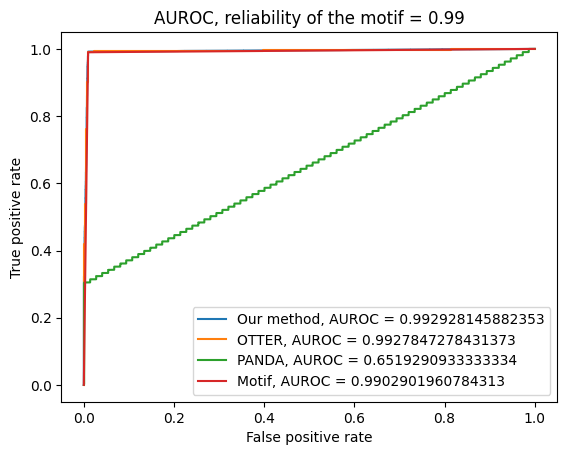

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.06 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    434407.878189  434390.576374  434414.985358  434379.927769   
1    434448.362519  434436.847354  434436.096636  434437.347337   
2    434409.209753  434399.730358  434402.941751  434408.341480   
3    434441.431136  434430.965376  434412.202626  434460.078303   
4    434418.882161  434421.506709  434401.080257  434395.736191   
..             ...            ...            ...            ...   
495  434413.927568  434378.629899  434405.919530  434382.687278   
496  434394.332819  434372.967777  434372.996964  434377.057752   
497  434417.330781  434404.613044  434410.972053  434431.677147   
498  434417.302913  434425.

step: 104, hamming: 73488427.72419602
step: 105, hamming: 60960679.277985506
step: 106, hamming: 50434194.353469975
step: 107, hamming: 41638275.9726381
step: 108, hamming: 34319720.59980413
step: 109, hamming: 28250500.488855284
step: 110, hamming: 23230330.640451357
step: 111, hamming: 19086315.77343586
step: 112, hamming: 15671039.182727369
step: 113, hamming: 12859947.64480889
step: 114, hamming: 10548520.186377756
step: 115, hamming: 8649499.782710902
step: 116, hamming: 7090332.97945235
step: 117, hamming: 5810879.234863047
step: 118, hamming: 4761409.59907164
step: 119, hamming: 3900883.7388783973
step: 120, hamming: 3195483.830479296
step: 121, hamming: 2617378.0624063625
step: 122, hamming: 2143683.524400364
step: 123, hamming: 1755601.3179779814
step: 124, hamming: 1437697.622135486
step: 125, hamming: 1177307.8391049362
step: 126, hamming: 964044.1724764782
step: 127, hamming: 789389.1673120878
step: 128, hamming: 646360.9268293963
step: 129, hamming: 529237.5728007155
step:

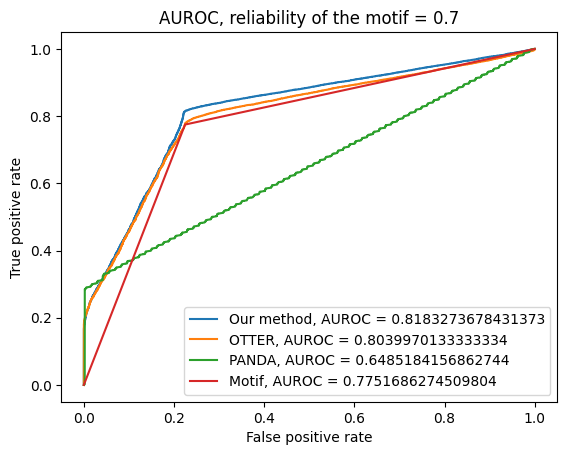

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    434372.581659  434381.042850  434385.182500  434385.171405   
1    434441.153316  434423.158671  434417.094808  434429.000301   
2    434450.767234  434420.707896  434461.694514  434425.015695   
3    434410.258523  434428.218584  434404.407394  434443.699167   
4    434454.964160  434417.258758  434417.260552  434409.400082   
..             ...            ...            ...            ...   
495  434420.170532  434374.125517  434403.401304  434408.046828   
496  434426.403045  434437.190759  434432.140611  434413.492400   
497  434396.367725  434396.505732  434414.130159  434395.447519   
498  434396.090864  434377.

step: 106, hamming: 2975961.340493538
step: 107, hamming: 3258510.5555485548
step: 108, hamming: 3619735.7980090487
step: 109, hamming: 4074446.7769351606
step: 110, hamming: 4639802.10633442
step: 111, hamming: 5335152.694148382
step: 112, hamming: 6181615.5983574595
step: 113, hamming: 7200822.350248283
step: 114, hamming: 8412413.63524405
step: 115, hamming: 9829739.787619183
step: 116, hamming: 11452649.874331856
step: 117, hamming: 13257239.203012561
step: 118, hamming: 15181996.72913759
step: 119, hamming: 17115069.31582229
step: 120, hamming: 18889257.820165154
step: 121, hamming: 20297174.42379584
step: 122, hamming: 21134607.1232955
step: 123, hamming: 21263086.44832558
step: 124, hamming: 20660666.734906297
step: 125, hamming: 19428674.46200561
step: 126, hamming: 17750583.91639534
step: 127, hamming: 15831266.332942965
step: 128, hamming: 13848899.956516309
step: 129, hamming: 11932955.961905856
step: 130, hamming: 10163069.204466097
step: 131, hamming: 8579212.94857072
step

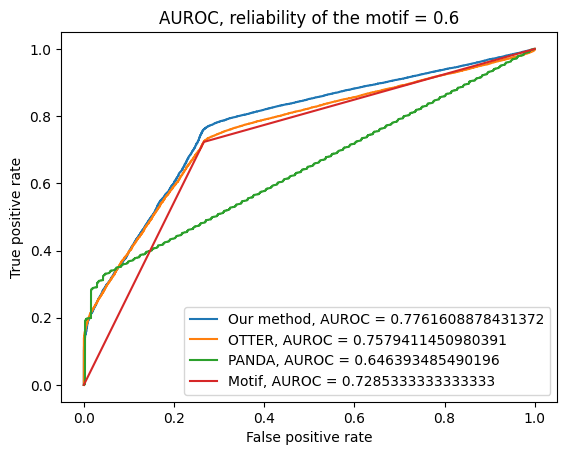

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.05 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    434376.329296  434403.367085  434385.063842  434401.653471   
1    434372.129293  434385.395742  434396.564568  434376.681095   
2    434407.644525  434424.919477  434418.051023  434419.880525   
3    434414.579320  434418.567948  434423.105755  434408.260651   
4    434350.404724  434359.761064  434380.587596  434347.975254   
..             ...            ...            ...            ...   
495  434429.942905  434429.366707  434426.466588  434444.640379   
496  434385.901071  434397.612509  434410.374176  434409.709383   
497  434403.376729  434419.331238  434408.008779  434392.755155   
498  434460.734931  434455.

step: 104, hamming: 19104845.17693897
step: 105, hamming: 21676316.9685216
step: 106, hamming: 24286176.39361136
step: 107, hamming: 26720645.490592785
step: 108, hamming: 28709220.739409316
step: 109, hamming: 29975106.793393675
step: 110, hamming: 30312671.914529607
step: 111, hamming: 29657755.00565288
step: 112, hamming: 28109173.220136713
step: 113, hamming: 25888563.754750416
step: 114, hamming: 23266124.06300514
step: 115, hamming: 20492980.0648608
step: 116, hamming: 17763189.98211826
step: 117, hamming: 15204894.041040886
step: 118, hamming: 12888988.82426391
step: 119, hamming: 10844035.418246979
step: 120, hamming: 9070747.742316933
step: 121, hamming: 7553427.107209814
step: 122, hamming: 6267978.620883821
step: 123, hamming: 5187100.712071149
step: 124, hamming: 4283411.076147995
step: 125, hamming: 3531169.959553021
step: 126, hamming: 2907121.7095052586
step: 127, hamming: 2390793.30258447
step: 128, hamming: 1964482.9698588178
step: 129, hamming: 1613077.8706084336
step

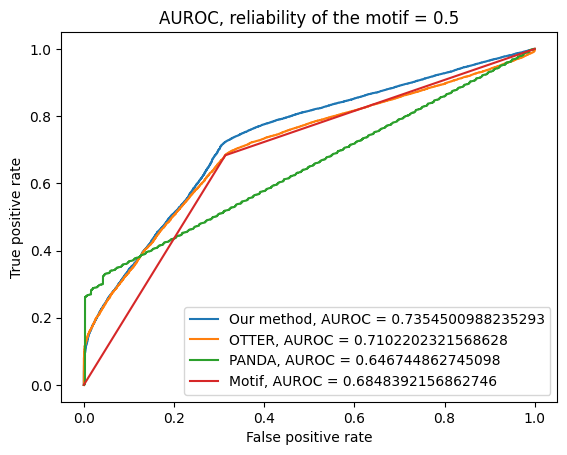

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.06 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    434423.907377  434448.382378  434417.438918  434418.935974   
1    434409.634366  434413.428915  434384.283611  434409.788530   
2    434412.682065  434396.915060  434426.257201  434414.027114   
3    434380.467456  434395.061490  434405.348180  434404.915401   
4    434410.618264  434389.230369  434407.625778  434436.522030   
..             ...            ...            ...            ...   
495  434407.737672  434391.879886  434405.256077  434397.288722   
496  434441.943244  434446.509810  434420.872401  434431.375011   
497  434421.700639  434409.428954  434406.376298  434421.136996   
498  434416.469378  434441.

step: 104, hamming: 5263303.858450059
step: 105, hamming: 4337805.370764602
step: 106, hamming: 3570442.1582331927
step: 107, hamming: 2935808.0200248635
step: 108, hamming: 2411993.1063941168
step: 109, hamming: 1980329.9403660318
step: 110, hamming: 1625054.5724780909
step: 111, hamming: 1332943.5973704914
step: 112, hamming: 1092960.995813077
step: 113, hamming: 895932.4350801195
step: 114, hamming: 734254.526347898
step: 115, hamming: 601640.9982489975
step: 116, hamming: 492904.4225477372
step: 117, hamming: 403770.6430163094
step: 118, hamming: 330722.25614122313
step: 119, hamming: 270867.4590642222
step: 120, hamming: 221830.6417520018
step: 121, hamming: 181661.48969346232
step: 122, hamming: 148759.66503877888
step: 123, hamming: 121812.55085392047
step: 124, hamming: 99743.89027606578
step: 125, hamming: 81671.46338940016
step: 126, hamming: 66872.26880759999
step: 127, hamming: 54753.89623615639
step: 128, hamming: 44831.00959823006
step: 129, hamming: 36706.04313584398
ste

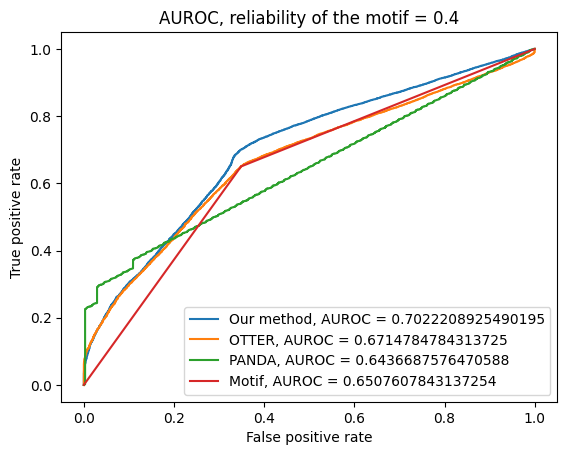

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.05 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    434393.594735  434411.239202  434396.532301  434408.251262   
1    434413.507857  434425.982564  434433.792884  434415.339385   
2    434354.662988  434355.840076  434373.069465  434353.746359   
3    434385.023129  434397.359013  434397.164429  434385.184037   
4    434407.903655  434392.431416  434423.821093  434409.853922   
..             ...            ...            ...            ...   
495  434388.477423  434424.191745  434405.418109  434406.718896   
496  434376.893648  434398.075277  434384.414718  434368.641870   
497  434390.415063  434383.344935  434396.645466  434410.590325   
498  434419.520071  434433.

step: 104, hamming: 2224139.441214429
step: 105, hamming: 2408574.928846595
step: 106, hamming: 2647503.9898457415
step: 107, hamming: 2951059.3534910614
step: 108, hamming: 3330981.381921146
step: 109, hamming: 3800584.9091299437
step: 110, hamming: 4374397.347804243
step: 111, hamming: 5067403.512821356
step: 112, hamming: 5893411.188859594
step: 113, hamming: 6862299.17266234
step: 114, hamming: 7975322.68699799
step: 115, hamming: 9218366.67519718
step: 116, hamming: 10553059.69920836
step: 117, hamming: 11907850.925590338
step: 118, hamming: 13173764.920149677
step: 119, hamming: 14212255.4095758
step: 120, hamming: 14881079.645364173
step: 121, hamming: 15074581.962913023
step: 122, hamming: 14760360.5712918
step: 123, hamming: 13990289.107400026
step: 124, hamming: 12879177.265338715
step: 125, hamming: 11565869.778958496
step: 126, hamming: 10178389.402748391
step: 127, hamming: 8814705.452385386
step: 128, hamming: 7538910.161783523
step: 129, hamming: 6385859.815897808
step: 

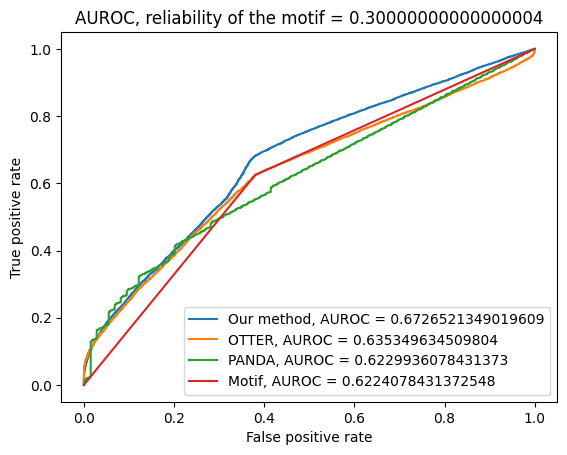

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.05 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt                 0              1              2              3   \
0    434419.130030  434440.751689  434419.238907  434405.789007   
1    434425.488165  434428.545535  434412.701656  434409.485247   
2    434389.118189  434379.726520  434368.000505  434374.517631   
3    434401.029097  434412.958352  434417.687749  434398.347865   
4    434413.441074  434442.973236  434416.524935  434410.040056   
..             ...            ...            ...            ...   
495  434422.314019  434422.094676  434415.617825  434424.586180   
496  434382.825129  434409.304281  434359.554003  434385.371074   
497  434411.431284  434412.374845  434423.017534  434421.785901   
498  434414.317593  434427.

step: 104, hamming: 3492595.591783372
step: 105, hamming: 3025427.1830743253
step: 106, hamming: 2588392.553157264
step: 107, hamming: 2193266.053283628
step: 108, hamming: 1844692.8173372974
step: 109, hamming: 1542640.0302930186
step: 110, hamming: 1284328.027220536
step: 111, hamming: 1065583.4799439884
step: 112, hamming: 881712.4292764344
step: 113, hamming: 728024.0208817273
step: 114, hamming: 600118.9811210128
step: 115, hamming: 494028.5465792446
step: 116, hamming: 406262.65969280456
step: 117, hamming: 333805.82628203183
step: 118, hamming: 274085.22582555766
step: 119, hamming: 224925.99492733256
step: 120, hamming: 184502.33234154384
step: 121, hamming: 151289.58019158398
step: 122, hamming: 124019.68450167618
step: 123, hamming: 101641.35149967087
step: 124, hamming: 83285.1592044878
step: 125, hamming: 68233.50906015026
step: 126, hamming: 55895.04005892948
step: 127, hamming: 45783.02527478545
step: 128, hamming: 37497.27241904999
step: 129, hamming: 30708.99347051508
s

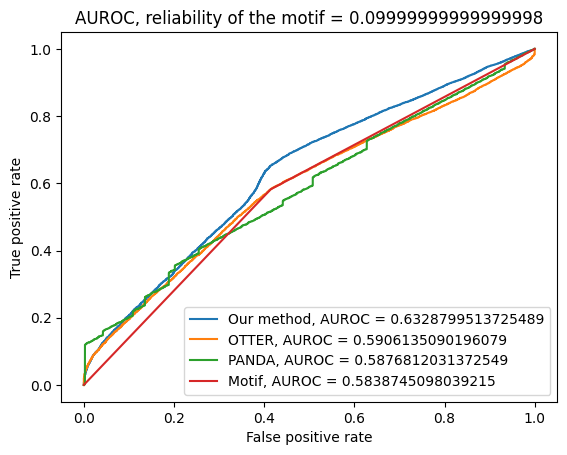

In [36]:
shuffling = [0.01, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]

scores = []
for shuffle in shuffling :
    scores.append(simulation(shuffling = shuffle))
    
giraffe.utils.star_plot(list(map(list, zip(*scores))), [str(round(1 - shuffle, 2)) for shuffle in shuffling], ["Our method", "OTTER", "PANDA", "Motif"])

In [40]:
import torch
def simulation(n = 50):

    tf = 100
    g = 500
    
    confounder = np.random.uniform(0, 1, n)
    ppi = generate_ppi(tf)
    TFA = generate_tfa(ppi, n)
    R = generate_regulation(g, tf, ppi)
    gene_expression = compute_expression(R, TFA, confounder)
    expr_limma = giraffe.limma(pd.DataFrame(confounder, columns = ['cf']), pd.DataFrame(gene_expression), 'cf', '~cf')
    motif = generate_motif(R)
    
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_adj = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001, adjusting = confounder).get_regulation()
    R_limma = giraffe.Giraffe(expr_limma, motif, ppi, lr = 0.0001).get_regulation()
    giraffe.plot_auroc(R.copy(), [R_giraffe, R_adj, R_limma, motif], ["GIRAFFE", "GIRAFFE adjusted", "GIRAFFE limma", "Motif"], title = "Hidden variable")
    
    gene_expression = R.dot(np.abs(TFA) + np.array([confounder for i in range(TFA.shape[0])])) + np.array([confounder for i in range(R.shape[0])])
    expr_limma = giraffe.limma(pd.DataFrame(confounder, columns = ['cf']), pd.DataFrame(gene_expression), pd.DataFrame(confounder, columns = ['cf']), '~ cf')
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_adj = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001, adjusting = confounder).get_regulation()
    R_limma = giraffe.Giraffe(expr_limma, motif, ppi, lr = 0.0001).get_regulation()
    giraffe.plot_auroc(R, [R_giraffe, R_adj, R_limma, motif], ["GIRAFFE", "GIRAFFE adjusted", "GIRAFFE limma", "Motif"], title = "Confounder")
    
    gene_expression = R.dot(np.abs(TFA) + np.array([confounder for i in range(TFA.shape[0])])) #+ np.array([confounder for i in range(R.shape[0])])
    expr_limma = giraffe.limma(pd.DataFrame(confounder, columns = ['cf']), pd.DataFrame(gene_expression), pd.DataFrame(confounder, columns = ['cf']), '~ cf')
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_adj = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001, adjusting = confounder).get_regulation()
    R_limma = giraffe.Giraffe(expr_limma, motif, ppi, lr = 0.0001).get_regulation()
    giraffe.plot_auroc(R, [R_giraffe, R_adj, R_limma, motif], ["GIRAFFE", "GIRAFFE adjusted", "GIRAFFE limma", "Motif"], title = "Causal sufficiency")

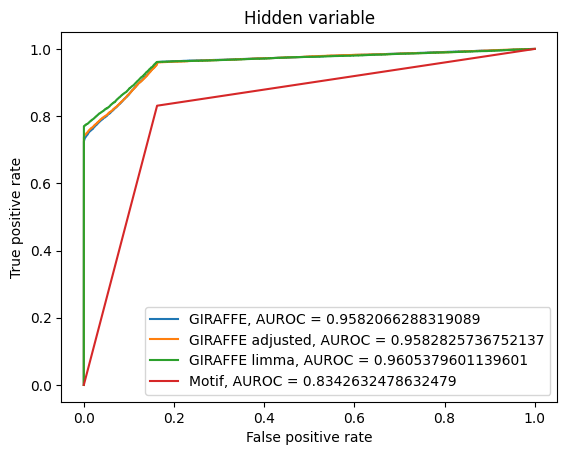

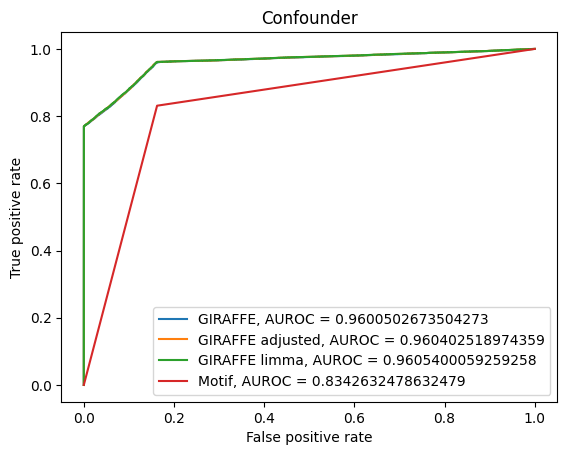

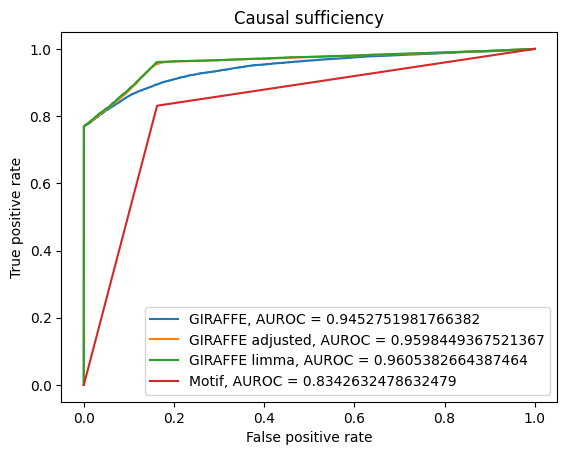

In [41]:
simulation()